# Introduction

We intend to produce a model based on BERT to infer capacity of predicting if a tweet can be categorized as an Alert tweet or not.

Some kernels have already implemented such models :

egortrushin/nlp-with-disaster-tweets-roberta-using-pytorch         NLP with Disaster Tweets: RoBERTa using PyTorch     Egor Trushin

ashishsingh226/disaster-tweet-classification-using-distil-bert     Disaster Tweet Classification using Distil Bert     AshishSingh226


We propose another implementation for BERT with fast-bert api on PyTorch

# Imports

In [16]:
import pandas as pd
pd.options.mode.chained_assignment = None

import torch
!pip install fast-bert
from fast_bert.data_cls import BertDataBunch
from fast_bert.learner_cls import BertLearner
from fast_bert.data_lm import BertLMDataBunch
from fast_bert.learner_lm import BertLMLearner
from fast_bert.metrics import fbeta, roc_auc
from fast_bert.prediction import BertClassificationPredictor
from pathlib import Path
import pandas as pd
import logging
import os
import pickle
from time import time
import seaborn as sns
import matplotlib.pyplot as plt
import re
!pip install emoji
import emoji

import warnings
warnings.filterwarnings('ignore')

logger = logging.getLogger()
device_cuda = torch.device("cuda")

# Datasets loading

In [19]:
train_data = pd.read_csv('./../dataset/train.csv',sep=",")

In [20]:
test_data = pd.read_csv('./../dataset/test.csv',sep=",")

In [21]:
print("Total rows in train data: ",train_data.shape[0])
print("Total columns in train data: ",train_data.shape[1])
print("-"*30)
print("Total rows in test data: ",test_data.shape[0])
print("Total columns in test data: ",test_data.shape[1])

Total rows in train data:  7613
Total columns in train data:  5
------------------------------
Total rows in test data:  3263
Total columns in test data:  4


In [22]:
train_data.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [23]:
test_data.describe()

,id
count,3263.000000
mean,5427.152927
std,3146.427221
min,0.000000
25%,2683.000000
50%,5500.000000
75%,8176.000000
max,10875.000000


In [24]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Data Exploration & Cleaning

In [25]:
print(train_data.isnull().sum())
print("-"*30)
print(test_data.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
------------------------------
id             0
keyword       26
location    1105
text           0
dtype: int64


We drop keyword and location columns as too many Nan and not really useful in the perspective of this classification objective.

In [26]:
train_data.groupby(train_data.target).count().text

target
0    4342
1    3271
Name: text, dtype: int64

/home/alpro/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


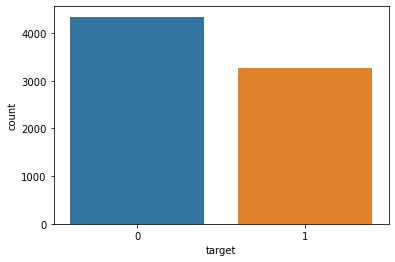

In [27]:
sns.countplot(train_data.target,data = train_data)
plt.show()

### Dropping keyword and location columns

In [30]:
train_data = train_data.drop(['keyword','location'], axis = 1)
test_data = test_data.drop(['keyword','location'], axis = 1)

In [31]:
train_data.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


# Preprocessing 

We need to remove superfluous data like url, emoji

In [33]:
import re
!pip install emoji
import emoji
def cleanTweet(txt):
    txt = re.sub(r'@[A-Za-z0-9_]+','',txt)
    txt = re.sub(r'#','',txt)
    txt = re.sub(r'RT : ','',txt)
    txt = re.sub(r'\n','',txt)
    # to remove emojis
    txt = re.sub(emoji.get_emoji_regexp(), r"", txt)
    txt = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+','',txt)
    txt = re.sub(r"https?://\S+|www\.\S+","",txt)
    txt = re.sub(r"<.*?>","",txt)
    return txt  

def make_Lower(text):
    return str.lower(text)

     |████████████████████████████████| 131 kB 4.3 MB/s eta 0:00:01


In [34]:
train_data.text = train_data.text.apply(cleanTweet)
train_data.text = train_data.text.apply(make_Lower)

test_data.text = test_data.text.apply(cleanTweet)
test_data.text = test_data.text.apply(make_Lower)

# Model